# Collocation

Computes collocation values for the words in the huggingface dataset.

In [18]:
from datasets import load_dataset
import re
from tqdm import tqdm
from collections import Counter
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt

Find the preprocessed data files created by `preprocess.ipynb`:

In [2]:
directory = 'preprocessed'
files = []
for filename in glob.iglob(f'{directory}/*.csv'):
    files.append(filename)
files.sort()
files

['preprocessed/0-10000.csv',
 'preprocessed/10000-20000.csv',
 'preprocessed/100000-110000.csv',
 'preprocessed/110000-120000.csv',
 'preprocessed/120000-130000.csv',
 'preprocessed/130000-140000.csv',
 'preprocessed/140000-150000.csv',
 'preprocessed/150000-160000.csv',
 'preprocessed/160000-170000.csv',
 'preprocessed/170000-180000.csv',
 'preprocessed/180000-190000.csv',
 'preprocessed/190000-200000.csv',
 'preprocessed/20000-30000.csv',
 'preprocessed/200000-210000.csv',
 'preprocessed/210000-220000.csv',
 'preprocessed/220000-230000.csv',
 'preprocessed/230000-240000.csv',
 'preprocessed/240000-250000.csv',
 'preprocessed/250000-260000.csv',
 'preprocessed/260000-270000.csv',
 'preprocessed/270000-280000.csv',
 'preprocessed/280000-287113.csv',
 'preprocessed/30000-40000.csv',
 'preprocessed/40000-50000.csv',
 'preprocessed/50000-60000.csv',
 'preprocessed/60000-70000.csv',
 'preprocessed/70000-80000.csv',
 'preprocessed/80000-90000.csv',
 'preprocessed/90000-100000.csv']

Getting all encoded articles into memory:

In [3]:
# converting the string of word IDs from the CSV file into numpy arrays
def str_to_array(str):
    return np.array(str.split(' ')).astype(int)

In [4]:
enc_docs = [] # a list containing the entire dataset's encoded articles
for file in files:
    print(file)
    df_prep = pd.read_csv(file, index_col=0)
    enc_docs += df_prep['encoding'].apply(lambda x: str_to_array(x)).tolist() # add this file's articles to the list
    

preprocessed/0-10000.csv
preprocessed/10000-20000.csv
preprocessed/100000-110000.csv
preprocessed/110000-120000.csv
preprocessed/120000-130000.csv
preprocessed/130000-140000.csv
preprocessed/140000-150000.csv
preprocessed/150000-160000.csv
preprocessed/160000-170000.csv
preprocessed/170000-180000.csv
preprocessed/180000-190000.csv
preprocessed/190000-200000.csv
preprocessed/20000-30000.csv
preprocessed/200000-210000.csv
preprocessed/210000-220000.csv
preprocessed/220000-230000.csv
preprocessed/230000-240000.csv
preprocessed/240000-250000.csv
preprocessed/250000-260000.csv
preprocessed/260000-270000.csv
preprocessed/270000-280000.csv
preprocessed/280000-287113.csv
preprocessed/30000-40000.csv
preprocessed/40000-50000.csv
preprocessed/50000-60000.csv
preprocessed/60000-70000.csv
preprocessed/70000-80000.csv
preprocessed/80000-90000.csv
preprocessed/90000-100000.csv


In [5]:
print('the dataset contains', len(enc_docs), 'documents')

the dataset contains 287113 documents


In [6]:
# computes a Counter object of all word IDs that occur around a specified word ID in the dataset

def collocation(token_to_find, context, database, counter_update=1000):
    """
    token_to_find: encoded ID of the word you want to find collocation values for
    context: size of the context window, how many words should be looked to either sides of the key word
    database: list of encoded documents
    counter_update: technical detail, does not affect result but may affect computation time. Just leave it.
    """
    coll = Counter()
    big_window = [] # temporary cache so the counter doesn't have to be updated at each document
    k = 0
    for i in tqdm(range(len(database))):
        doc = database[i]
        end = len(doc)
        if np.sum(doc == token_to_find) >= 1:
            for j in np.arange(len(doc))[doc == token_to_find]:
                big_window += doc[max(0, j - context):j].tolist()
                big_window += doc[j + 1:min(end, j + context + 1)].tolist()
                k += 1
                if k % 1000 == 0: #the counting is faster if you don't update the counter at each document
                    coll += Counter(big_window)
                    big_window = []
                    k = 0
                
    coll += Counter(big_window)
    return coll

In order to endode and decode words, we need to read the preprocessed word file, containing word IDs:

In [7]:
word_df = pd.read_csv('dataset_words.csv', index_col=0)

Using this, we can find collocations by specifying a word rather than a word ID.

In [8]:
def collocation_word(word_to_find, encode_df, decode_df, context, database, idf=False):
    """
    word_to_find: word you want to find collocation values for
    encode_df: dataframe with words as index and a column named 'id' containing IDs for those words
    decode_df: dataframe with word IDs as index and a column named 'word' containing corresponding words
    context: size of the context window, how many words should be looked to either sides of the key word
    database: list of encoded documents
    idf: boolean parameter, specifies whether or not the found collocations should be corrected for using the inverse document frequency
    """
    # encode the word to find
    token_to_find = encode_df['id'][word_to_find]
    
    # find collocations
    coll = collocation(token_to_find, context, database).most_common()
    
    # decode the found collocations
    new_coll = []
    if idf:
        for pair in coll:
            if pair[0] >= 0:
                new_coll.append((word_df_id['word'][pair[0]], pair[1] * -np.log(word_df_id['avg_doc_count'][pair[0]])))
    else:
        for pair in coll:
            if pair[0] >= 0:
                new_coll.append((word_df_id['word'][pair[0]], pair[1]))
    return sorted(new_coll, key=lambda x: x[1], reverse=True)

`word_df` has words as index, so it can be used to encode words quicky. In order to decode words quicky, we make another DataFrame that has word IDs as index.

In [9]:
word_df_id = word_df.set_index('id')
word_df_id['word'] = word_df.index
word_df_id

,word_count,doc_count,avg_word_count,avg_doc_count,word
id,,,,,
0,11335042,286985,39.479376,0.999554,the
1,4839516,286640,16.855788,0.998353,a
2,5382863,286610,18.748238,0.998248,to
3,4631023,286374,16.129618,0.997426,and
4,4101247,286285,14.284435,0.997116,in
...,...,...,...,...,...
656685,1,1,0.000003,0.000003,jacobius
656686,1,1,0.000003,0.000003,pennison
656687,1,1,0.000003,0.000003,fresh-out-of-college


Using these DataFrames, we can compute collocations for words rather than word IDs.

In [17]:
dict(collocation_word('death', word_df, word_df_id, 5, enc_docs, idf=True))

100%|██████████| 287113/287113 [00:02<00:00, 113644.31it/s]


{'penalty': 17089.419230115425,
 'her': 14793.83573606411,
 'toll': 10134.745713576742,
 'cause': 10059.25036058375,
 'stabbed': 8602.481065700751,
 'his': 7899.703970160182,
 'row': 6539.346527026737,
 'sentenced': 5605.408550291843,
 'inquest': 5465.146235288466,
 'tragic': 5061.576144334135,
 'threats': 4899.985591957141,
 'following': 4785.213693936577,
 'sentence': 4651.702399038495,
 'son': 4297.48932895478,
 'jackson': 4180.829778841436,
 'accidental': 4101.159765124109,
 'mr': 4095.3910688373267,
 'she': 4089.388652603299,
 'murder': 4046.595292090354,
 'causing': 3935.302207325322,
 'before': 3865.91323295886,
 'sudden': 3778.634753637144,
 'police': 3514.492448925104,
 'after': 3133.61804471781,
 'shooting': 3125.578877443616,
 'wrongful': 3102.5285339075363,
 'father': 2990.5907969321484,
 'mother': 2979.24395894945,
 'daughter': 2974.7412644195897,
 'circumstances': 2911.7615628569993,
 'coroner': 2899.104174710173,
 'investigation': 2809.8751403795804,
 'shot': 2701.033328

Or we can make a nice-looking graph:

In [35]:
def collocation_graph(word, n=10, idf=True):
    ls = collocation_word(word, word_df, word_df_id, 5, enc_docs, idf=idf)
    top_n_words = ls[:min(n, len(ls))]
    
    plt.rcdefaults()
    fig, ax = plt.subplots()
    
    words = [t[0] for t in top_n_words][::-1]
    counts = [t[1] for t in top_n_words][::-1]

    plt.barh(words,counts)
    plt.title('Collocation values for \'' + word + '\'')
    plt.xlabel('Collocation score')
    plt.show()

100%|██████████| 287113/287113 [00:01<00:00, 158326.91it/s]


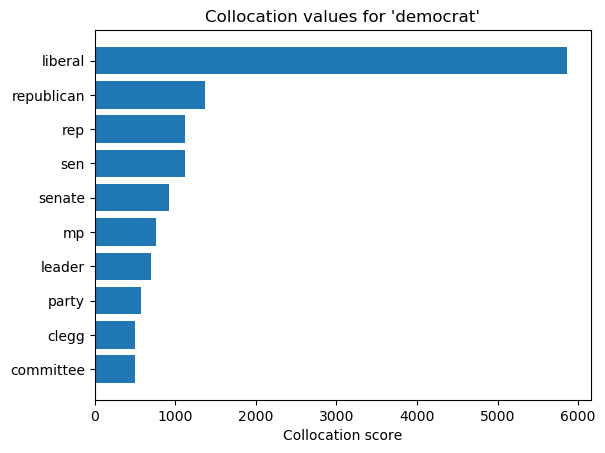

In [64]:
collocation_graph('democrat')